In [1]:
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore')

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic",
        rc={"axes.unicode_minus":False},
        style='darkgrid')

#GPU 사용 설정, -1이면 CPU 사용
# os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for i in range(len(gpus)):
            tf.config.experimental.set_memory_growth(gpus[i], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## 결과 2) method1_entropy

- **LSH ⇒ 최종 모델 정리 (val_acc, crossvalidation)**
- method1_entropy에 대한 정성적 비교..
- method1_entropy : ( E(0to1) - E(1to0) ) * entropy
- top10에 대해서 조사한 내용 표로 만들기

**A4용지 절반 나눠서 위에 사망_표, 사망_absum / 생존_표, 생존_absum 제시**

- **guri, kelly ⇒ 표 내용, 스토리텔링**
- PRE, PRO, LAB 나눌 수는 있지만.. 복잡함 (합치는 게 나을 듯)
- 사망marker, 생존marker에 대한 top5를 각각 고르는 방안 고려...

**absum 그래프 그림**

## all fit LSTM

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

import random
import sklearn

path = '/project/LSH/'
with tf.device('/device:GPU:0'):

    x = np.load(path + 'x_(7727,10,4068).npy')
    y = np.load(path + 'y_(7727,1).npy')

    # LSTM model

    seed_num = 42 # model_seed
    tf.random.set_seed(seed_num)

    lstm = Sequential()
    lstm.add(InputLayer(input_shape=(x.shape[1],x.shape[2])))
    lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(units=1, activation='sigmoid'))

    # Best model saving
    from tensorflow.keras.callbacks import ModelCheckpoint
    import os

    MODEL_SAVE_FOLDER_PATH = f'./models/'
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
        os.mkdir(MODEL_SAVE_FOLDER_PATH)

    model_path = MODEL_SAVE_FOLDER_PATH + '/seed42-{epoch:02d}-val_loss:{val_loss:.4f}.hdf5'

    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                    verbose=1, save_best_only=True)

    early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=False)
    
    lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
    lstm.fit(x, y, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)


Epoch 1/500
46/46 [==============================] - 6s 74ms/step - loss: 0.6458 - acc: 0.6511 - val_loss: 0.6934 - val_acc: 0.4865

Epoch 00001: val_loss improved from inf to 0.69343, saving model to ./models/seed42-01-val_loss:0.6934.hdf5
Epoch 2/500
46/46 [==============================] - 3s 65ms/step - loss: 0.6740 - acc: 0.6066 - val_loss: 0.7237 - val_acc: 0.4865

Epoch 00002: val_loss did not improve from 0.69343
Epoch 3/500
46/46 [==============================] - 3s 65ms/step - loss: 0.6651 - acc: 0.6419 - val_loss: 0.7362 - val_acc: 0.4865

Epoch 00003: val_loss did not improve from 0.69343
Epoch 4/500
46/46 [==============================] - 3s 65ms/step - loss: 0.6369 - acc: 0.6518 - val_loss: 0.6848 - val_acc: 0.4865

Epoch 00004: val_loss improved from 0.69343 to 0.68478, saving model to ./models/seed42-04-val_loss:0.6848.hdf5
Epoch 5/500
46/46 [==============================] - 3s 65ms/step - loss: 0.5325 - acc: 0.7367 - val_loss: 0.5728 - val_acc: 0.7091

Epoch 00005: 


Epoch 00040: val_loss did not improve from 0.55282
Epoch 41/500
46/46 [==============================] - 3s 65ms/step - loss: 0.0836 - acc: 0.9805 - val_loss: 1.0679 - val_acc: 0.7283

Epoch 00041: val_loss did not improve from 0.55282
Epoch 42/500
46/46 [==============================] - 3s 65ms/step - loss: 0.0923 - acc: 0.9769 - val_loss: 1.0395 - val_acc: 0.7277

Epoch 00042: val_loss did not improve from 0.55282
Epoch 43/500
46/46 [==============================] - 3s 65ms/step - loss: 0.0859 - acc: 0.9788 - val_loss: 1.0563 - val_acc: 0.7293

Epoch 00043: val_loss did not improve from 0.55282
Epoch 44/500
46/46 [==============================] - 3s 65ms/step - loss: 0.0828 - acc: 0.9812 - val_loss: 1.0942 - val_acc: 0.7226

Epoch 00044: val_loss did not improve from 0.55282
Epoch 45/500
46/46 [==============================] - 3s 65ms/step - loss: 0.0792 - acc: 0.9826 - val_loss: 1.0943 - val_acc: 0.7226

Epoch 00045: val_loss did not improve from 0.55282
Epoch 46/500
46/46 [===

In [12]:
model = tf.keras.models.load_model('/project/guri/ForPaper/models/seed42-18-val_acc:0.7588.hdf5')
pred = model.predict(x)
pred[pred>0.5]=1
pred[pred<=0.5]=0
metrics.accuracy_score(y, pred)

0.8921961951598292

# Method1 - all fit 사용 + lambda
일관성, 방향성 고려한 feature 탐지 <br>
**goal : 사망/생존 마커 탐지** <br>
- Score 계산 식

  - <div> $Score = {E(0to1) - E(1to0)} * Entropy^{ λ}$ </div>

- $E(0to1), E(1to0)$
  1. X의 각 feature의 값(4068개)을 모두 1, 0로 바꾸어 예측
  2. 예측값 리스트의 평균값 계산
  3. 1로 바꾼 E(0to1)에서 0으로 바꾼 E(0to1)을 뺀다.
  
- `Entropy([proportion of 1, proportion of 0])^{λ}` 를 곱해준다.
  - λ (0 or 1) 적용 (0이면 entropy X, 1이면 entropy O)

In [73]:
path = '/project/LSH/'
# model_path = path + 'model/allfit_ep500/allfit_ep500_seed42-17-0.7619.hdf5'

#guri모델
model_path = '/project/guri/ForPaper/models/seed42-06-val_loss:0.5528.hdf5'

In [47]:
COLS = list(pd.read_csv(path + 'total_data_7727.csv')['ITEMID'].sort_values().unique())
x = np.load(path + 'x_(7727,10,4068).npy')
y = np.load(path + 'y_(7727,1).npy')

In [48]:
def entropy(ratio_list):
    one_ratio, zero_ratio = ratio_list[0], ratio_list[1] 
    if (one_ratio == 0) or (zero_ratio == 0):
        return 0.0
    return - ((one_ratio * (np.log2(one_ratio))) + (zero_ratio * (np.log2(zero_ratio))))

# def H(p):
#     id_p = np.where(p != 0)
#     return -np.sum(p[id_p]*np.log2(p[id_p]))

X = np.load('/project/LSH/x_(7727,10,4068).npy')

entropy_dict = {}
for i in tqdm(range(len(COLS))):
    one_ratio = X[:,:,i].sum() / (X.shape[0]*X.shape[1])
    zero_ratio = 1 - one_ratio
    entropy_num = entropy([one_ratio, zero_ratio])
    entropy_dict[COLS[i]] = entropy_num

  0%|          | 0/4068 [00:00<?, ?it/s]

In [49]:
entropy_dict

{0: 0.8945475095722644,
 50803: 0.033442542699476635,
 50804: 0.48487374976369707,
 50805: 0.0011721468075888046,
 50806: 0.07466452012902748,
 50808: 0.3422567690915075,
 50809: 0.30631983549914066,
 50811: 0.17607571914919884,
 50813: 0.3020503924033536,
 50814: 0.0013473569150405915,
 50818: 0.5905150583063137,
 50820: 0.5572216411567222,
 50821: 0.6928844725130754,
 50822: 0.14596543633389195,
 50824: 0.075539219929809,
 50852: 0.028723919067390347,
 50853: 0.0018581977954349603,
 50856: 0.007513335654158085,
 50858: 0.0,
 50861: 0.4000048713984587,
 50862: 0.4705525702453669,
 50863: 0.4083236220110865,
 50864: 0.0011721468075888046,
 50865: 0.0025135191238101528,
 50866: 0.02373004513245036,
 50867: 0.11824848231980385,
 50868: 0.2937998951444971,
 50871: 0.0,
 50872: 0.0,
 50873: 0.0006248993908785407,
 50876: 0.00022881204196882252,
 50877: 0.00022881204196882252,
 50878: 0.45076509428156675,
 50881: 0.0018581977954349603,
 50882: 0.7677642918971788,
 50883: 0.07702015471713725

In [74]:
model = tf.keras.models.load_model(model_path)
pred = model.predict(X)
pred[pred>0.5]=1
pred[pred<=0.5]=0
metrics.accuracy_score(y, pred)

0.7981105215478194

In [55]:
# idx = [COLS.index(i) for i in [51277, 51006, 50912, 409176230, 50882,50893, 50983, 51003, 50862, 51274]]
idx = [COLS.index(i) for i in [51006, 51277, 50893, 50912, 50882, 409176230, 51244, 536338101, 51003, 173024256]]

In [56]:
with tf.device('/device:GPU:0'): 
    model = tf.keras.models.load_model(model_path)
    result = []
    for i in tqdm(idx):
        save_cols = X[:,:,i].copy()
        #-----zero2one-----
        X[:,:,i] = 1
        pred1 = model.predict(X, batch_size=10000, workers=-1, use_multiprocessing=True)
        mean_pred1 = np.mean(pred1)
        #-----one2zero-----
        X[:,:,i] = 0
        pred2 = model.predict(X, batch_size=10000, workers=-1, use_multiprocessing=True)
        mean_pred2 = np.mean(pred2)

        result.append({'feature' : str(COLS[i]), 'zero2one' : mean_pred1, 'one2zero' : mean_pred2,
                       'lambda0' : mean_pred1 - mean_pred2, 'lambda1' : (mean_pred1 - mean_pred2) * entropy_dict[COLS[i]]})
        #값 복원
        X[:,:,i] = save_cols

  0%|          | 0/10 [00:00<?, ?it/s]

In [57]:
pd.DataFrame(result)

,feature,zero2one,one2zero,lambda0,lambda1
0,51006,0.604034,0.517013,0.087022,0.085363
1,51277,0.631312,0.514250,0.117062,0.107619
2,50893,0.588623,0.538878,0.049745,0.044339
3,50912,0.604634,0.536202,0.068433,0.058050
4,50882,0.598485,0.540656,0.057829,0.044399
5,409176230,0.661680,0.542477,0.119203,0.045372
6,51244,0.581516,0.549361,0.032155,0.018393
7,536338101,0.547627,0.553697,-0.006071,-0.002197
8,51003,0.637546,0.548944,0.088602,0.029238
9,173024256,0.651770,0.549909,0.101861,0.018839


In [ ]:
with tf.device('/device:GPU:0'): 
    model = tf.keras.models.load_model(model_path)
    result = []
    for i in tqdm(range(X.shape[2])):
        save_cols = X[:,:,i].copy()
        #-----zero2one-----
        X[:,:,i] = 1
        pred1 = model.predict(X, batch_size=10000, workers=-1, use_multiprocessing=True)
        mean_pred1 = np.mean(pred1)
        #-----one2zero-----
        X[:,:,i] = 0
        pred2 = model.predict(X, batch_size=10000, workers=-1, use_multiprocessing=True)
        mean_pred2 = np.mean(pred2)

        result.append({'feature' : str(COLS[i]), 'zero2one' : mean_pred1, 'one2zero' : mean_pred2,
                       'lambda0' : mean_pred1 - mean_pred2, 'lambda1' : (mean_pred1 - mean_pred2) * entropy_dict[COLS[i]]})
        #값 복원
        X[:,:,i] = save_cols

  0%|          | 0/4068 [00:00<?, ?it/s]

In [ ]:
#guri 모델 사용
df = pd.DataFrame(result)
df.to_csv('./Result2,3_guri.csv', index=False)
df.sort_values('lambda1', ascending=False)

In [ ]:
#LSH 모델 사용시
# df = pd.DataFrame(result)
# df.to_csv('./Result2,3.csv', index=False)
# df.sort_values('lambda1', ascending=False)

In [6]:
df = pd.DataFrame(result)
df.to_csv('./Result2,3.csv', index=False)
df.sort_values('lambda1', ascending=False)

,feature,zero2one,one2zero,lambda0,lambda1
206,51277,0.703606,0.618675,0.084931,0.078080
121,51006,0.690700,0.613917,0.076783,0.075320
41,50893,0.672248,0.629832,0.042416,0.037807
56,50912,0.675136,0.632141,0.042995,0.036471
2148,409176230,0.720902,0.635216,0.085686,0.032615
...,...,...,...,...,...
4049,68734070010,0.642188,0.640470,0.001718,NaN
4051,68774060001,0.640835,0.640470,0.000365,NaN
4061,76329301205,0.640438,0.640470,-0.000032,NaN
4062,76336045517,0.638466,0.640470,-0.002003,NaN


# Result2 TOP10

In [62]:
result2 = pd.read_csv('Result2,3_guri_loss.csv').sort_values('lambda1', ascending=False)
result2

,feature,zero2one,one2zero,lambda0,lambda1
206,51277,0.631312,0.514250,0.117062,0.107619
121,51006,0.604034,0.517013,0.087022,0.085363
56,50912,0.604634,0.536202,0.068433,0.058050
2148,409176230,0.661680,0.542477,0.119203,0.045372
34,50882,0.598485,0.540656,0.057829,0.044399
...,...,...,...,...,...
2189,409490234,0.503593,0.558696,-0.055103,-0.032587
0,0,0.541652,0.580313,-0.038661,-0.034584
619,8084199,0.504708,0.565007,-0.060299,-0.036825
19,50861,0.458146,0.558776,-0.100631,-0.040253


In [66]:
# result2 = pd.read_csv('/project/kelly/final_Method1_entropy.csv')
# result2 = result2.sort_values('method1_entropy', ascending=False).reset_index(drop=True)
# result2[-11:]

# Result3 TOP10

In [67]:
# result3 = pd.read_csv('/project/kelly/final_Method1_부록.csv')
# result3 = result3.sort_values('method1_부록', ascending=False).reset_index(drop=True)
# result3

In [68]:
result3 = pd.read_csv('Result2,3_guri_loss.csv').sort_values('lambda0', ascending=False)
result3

,feature,zero2one,one2zero,lambda0,lambda1
2195,409606211,0.713736,0.550595,0.163141,0.009637
1081,67434504,0.694880,0.551605,0.143275,0.007954
1276,74606211,0.677882,0.552095,0.125787,0.005621
2148,409176230,0.661680,0.542477,0.119203,0.045372
1011,54858516,0.669945,0.552062,0.117883,0.004974
...,...,...,...,...,...
3113,51079028520,0.474246,0.553901,-0.079656,-0.007258
2106,406051262,0.470409,0.554297,-0.083889,-0.011011
2824,17714002001,0.467975,0.554750,-0.086774,-0.011261
469,4003822,0.462087,0.553476,-0.091389,-0.004120


In [71]:
result3[-10:][::-1]

,feature,zero2one,one2zero,lambda0,lambda1
19,50861,0.458146,0.558776,-0.100631,-0.040253
469,4003822,0.462087,0.553476,-0.091389,-0.004120
2824,17714002001,0.467975,0.554750,-0.086774,-0.011261
2106,406051262,0.470409,0.554297,-0.083889,-0.011011
3113,51079028520,0.474246,0.553901,-0.079656,-0.007258
3852,63323038810,0.473612,0.553233,-0.079620,-0.001206
1551,93521193,0.477063,0.555329,-0.078266,-0.015507
1034,56017275,0.477982,0.555977,-0.077995,-0.014718
2047,338268975,0.476843,0.553452,-0.076608,-0.003378
64,50924,0.480190,0.554006,-0.073816,-0.006199


# Visualization

In [63]:
X = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')
# 컬럼이름 로드
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())

#death_index
d_index = np.where(y==1)[0]
#survive_index (퇴원 환자)
s_index = np.where(y==0)[0]

#사망/퇴원 환자 분리
d_X = X[d_index]
s_X = X[s_index]

result = []
result_s = []
#day - 10일
for d in range(10):
    #4068 - ITEM
    for f in range(d_X.shape[-1]):
        d_sum = d_X[:,d,f].sum()/d_X.shape[0]
        s_sum = s_X[:,d,f].sum()/s_X.shape[0]
        result.append({'cols':COLS[f], 'day':10-d,'per':d_sum})
        result_s.append({'cols':COLS[f], 'day':10-d,'per':s_sum})
        
d_df = pd.DataFrame(result).sort_values(['cols','day']).reset_index(drop=True)
s_df = pd.DataFrame(result_s).sort_values(['cols','day']).reset_index(drop=True)
d_df.shape, s_df.shape

def visualization(top10_list):
    plt.figure(figsize = (13,12), dpi=150)
    i = 0
    for f in top10_list:
        if f == 0:
            continue
        plt.subplot(4,3,1+i)
        plt.title(f)
        ax = sns.lineplot(data = d_df[d_df['cols']==int(f)], x = 'day', y='per', label='사망')
        ax = sns.lineplot(data = s_df[s_df['cols']==int(f)], x = 'day', y='per', label='퇴원')
        ax.invert_xaxis()
        ax.legend(loc='upper left')
        i += 1
    plt.tight_layout()

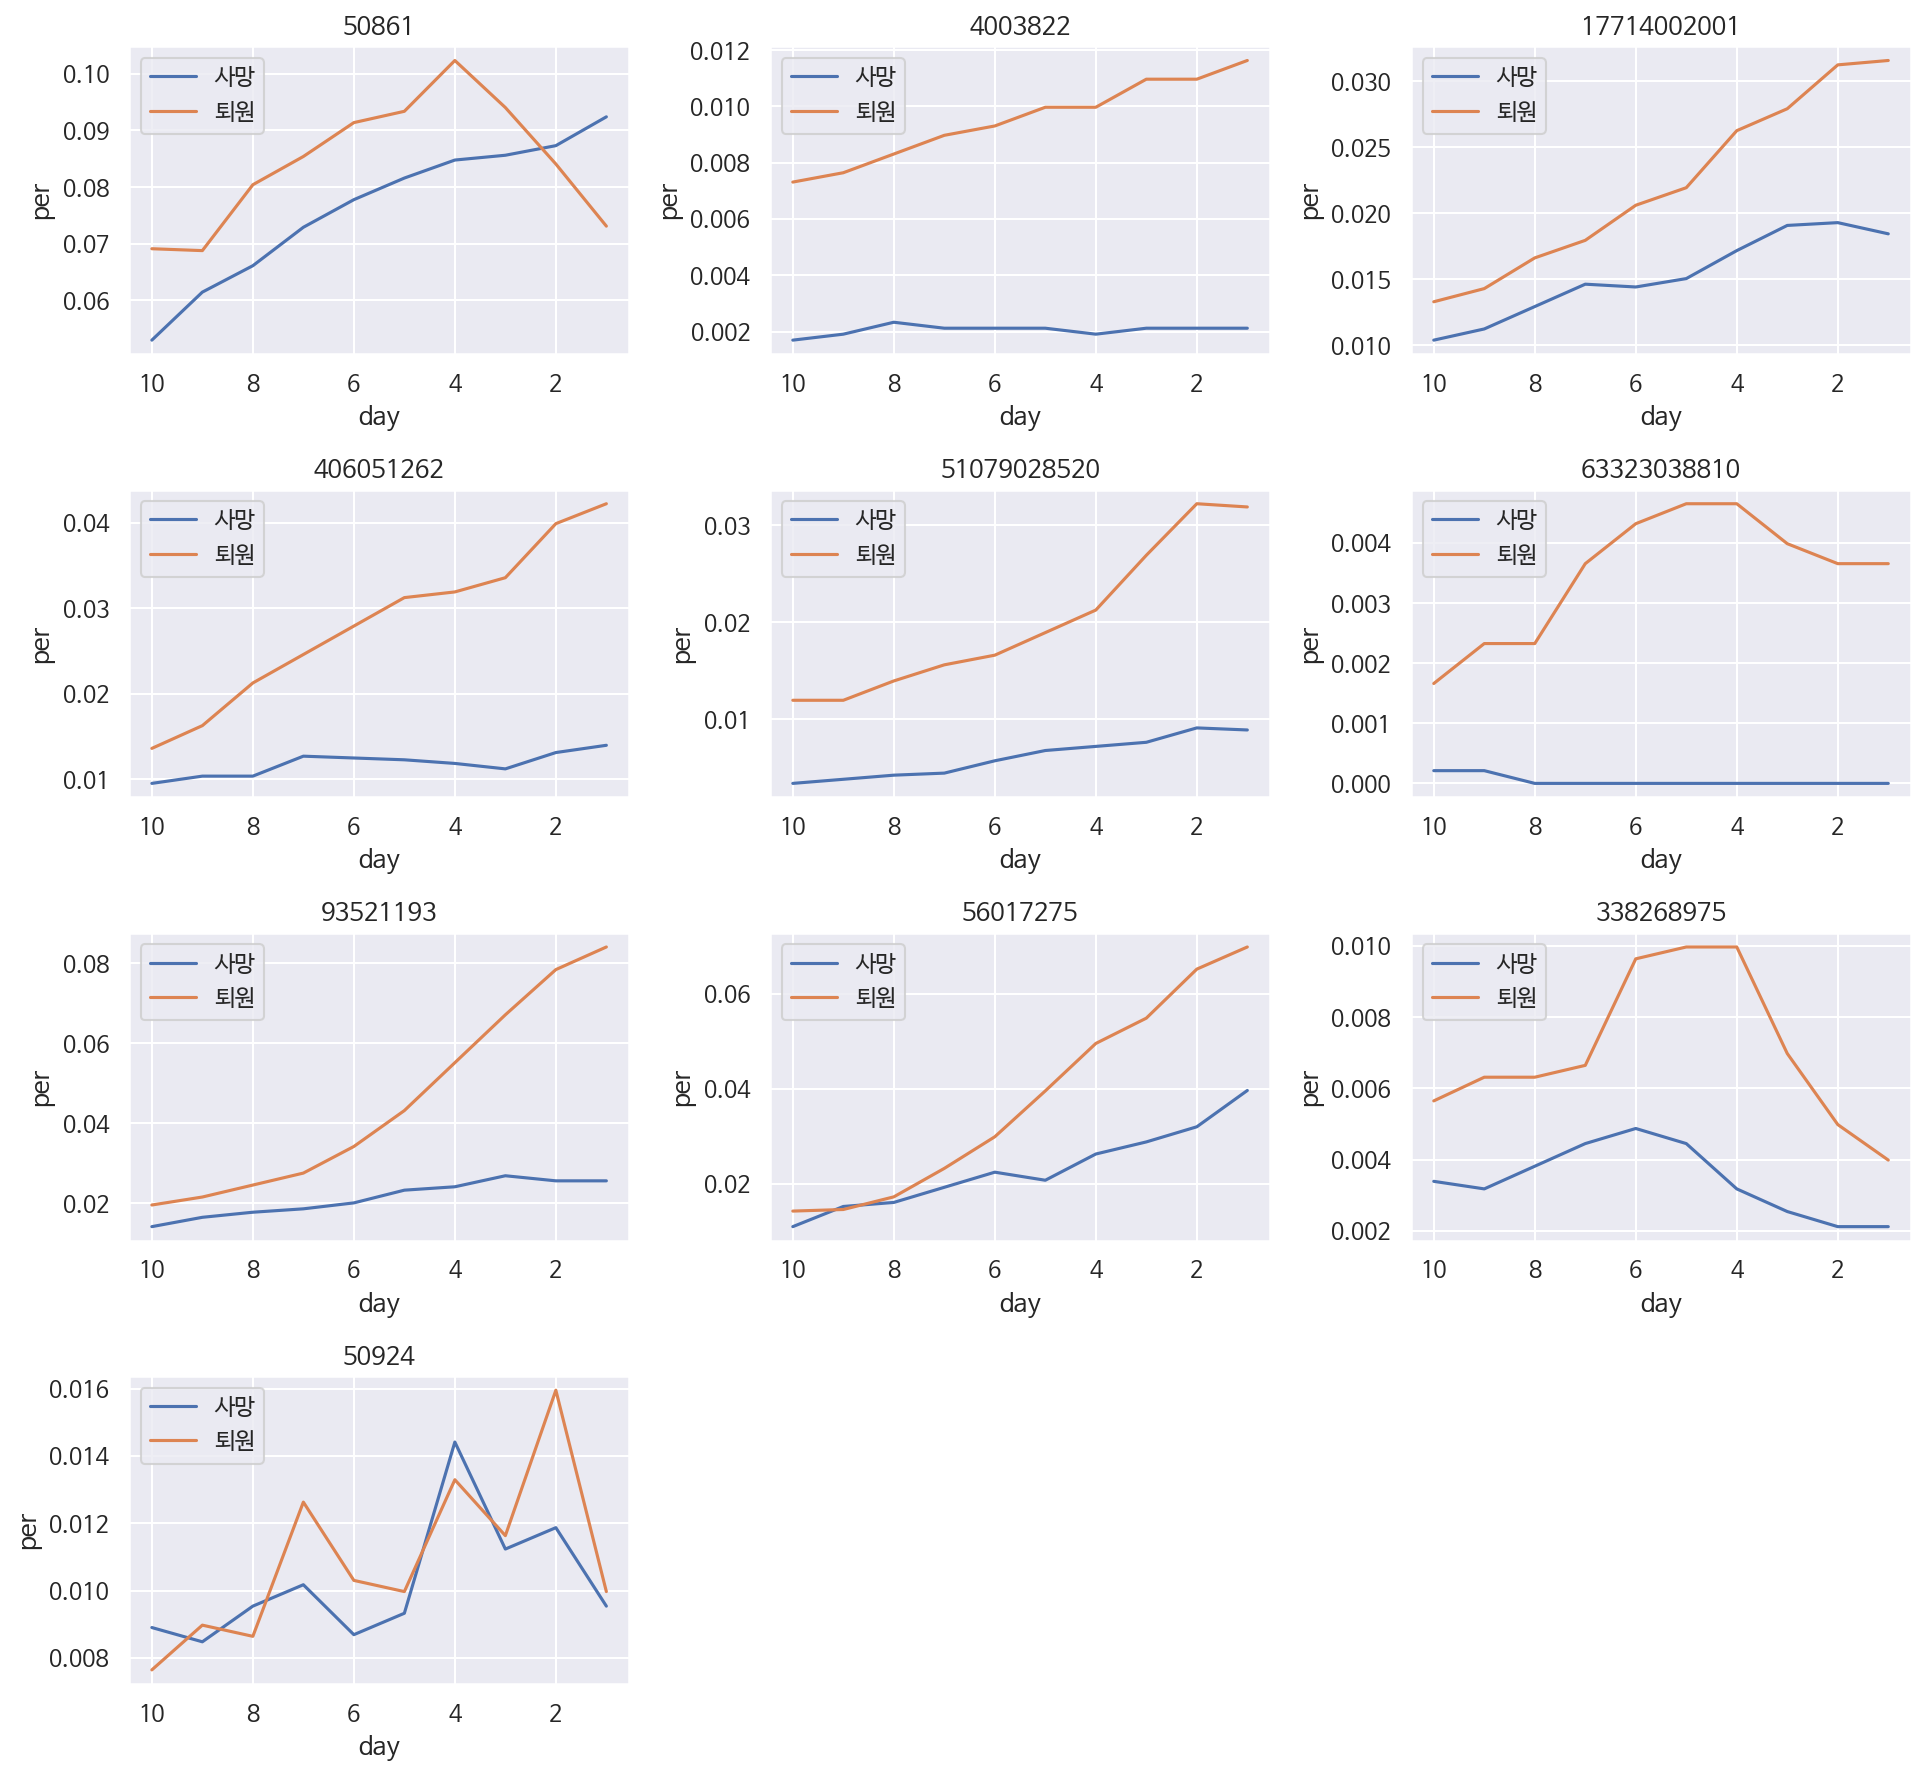

In [72]:
visualization(result3[-10:][::-1]['feature'])